# Define the Search Area: Amazon Tile 20LKP in July 2024

To locate relevant satellite data over the Amazon region, we first define a search path based on a known Sentinel-2 tiling grid:

In [2]:
import boto3
from botocore.config import Config
from botocore import UNSIGNED

# This sets up our connection to AWS S3
# We use UNSIGNED to specify we are accessing a public bucket
# and don't need credentials.
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# The name of the public bucket for Sentinel-2 Level-2A data
bucket_name = 'sentinel-s2-l2a'

print("Successfully created an S3 client to connect to public buckets.")

Successfully created an S3 client to connect to public buckets.


Let's search for Sentinel-2 Level-2A Red band data (specifically, the B04.jp2 file) in a public AWS S3 bucket for a specific tile over the Amazon region during July 2024.

In [3]:
# We are defining the "folder" we want to search inside.
# This corresponds to tile 20LKP in the Amazon, during July 2023.
search_prefix = 'tiles/20/L/KP/2024/7/'

print(f"Search area defined. We will look for files inside: {search_prefix}")

Search area defined. We will look for files inside: tiles/20/L/KP/2024/7/


In [4]:
# A paginator helps us look through long lists of files page by page.
paginator = s3.get_paginator('list_objects_v2')

# We will store the full path to the file we find in this variable.
red_band_key = None

print("Searching for the first available Red band (B04.jp2)...")

# We loop through all the files in our search_prefix.
for page in paginator.paginate(Bucket=bucket_name, Prefix=search_prefix):
    # The 'Contents' key might not exist if a page is empty.
    if "Contents" in page:
        for obj in page['Contents']:
            key = obj['Key']
            # Check if the file is the one we want.
            if key.endswith('B04.jp2'):
                red_band_key = key  # We found it! Store the full path.
                print(f"Success! Found file: {red_band_key}")
                break  # Exit the inner loop.
    if red_band_key:
        break # Exit the outer loop since we found our file.

# Final check to make sure we found something.
if red_band_key is None:
    print("Could not find any 'B04.jp2' file in the specified month.")

Searching for the first available Red band (B04.jp2)...
Success! Found file: tiles/20/L/KP/2024/7/1/0/R10m/B04.jp2


In [5]:
# The name we'll save the file as locally.
local_filename = 'B04.jp2'

print(f"Downloading file: {red_band_key}")
print(f"Saving it as: {local_filename}")

# This is the command that performs the download.
s3.download_file(bucket_name, red_band_key, local_filename)

print("Download complete.")

Saving it as: B04.jp2
Download complete.


Let's open and visualize the Sentinel-2 Red band image (B04.jp2) previously downloaded. We user `rasterio` for reading geospatial raster data and `matplotlib` for visualization.

Opening the downloaded file with rasterio...

File details:
  - Coordinate Reference System: EPSG:32720
  - Dimensions: 10980 x 10980 pixels
  - Number of bands: 1


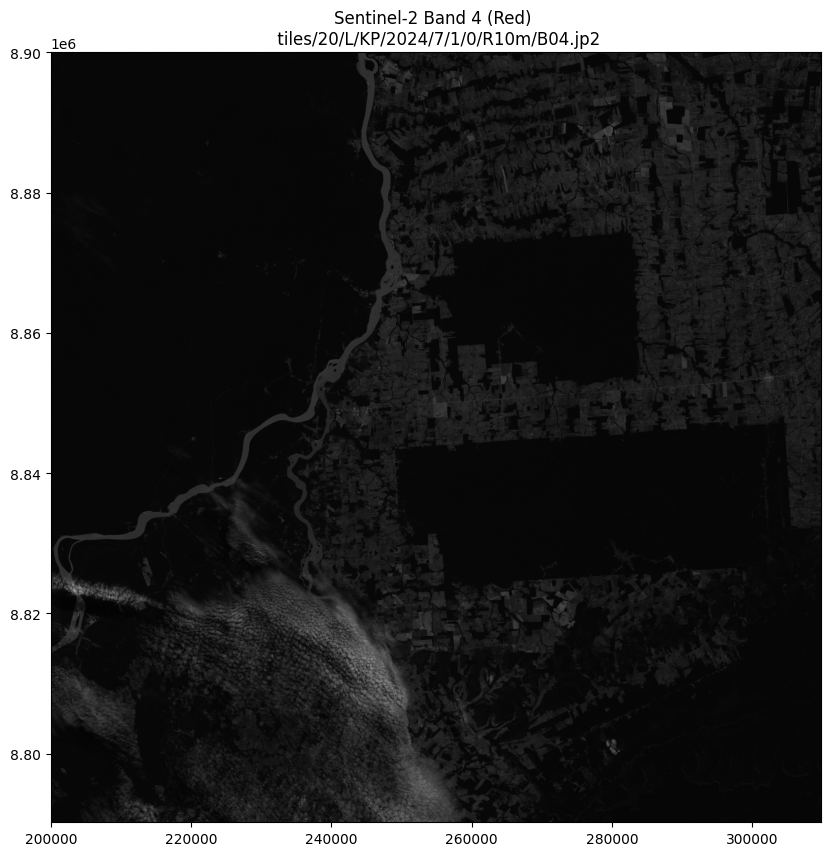

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# The local file you just downloaded
local_filename = 'B04.jp2'

print("Opening the downloaded file with rasterio...")

# Rasterio opens the file and lets us work with it.
# The 'with' statement ensures the file is properly closed afterwards.
with rasterio.open(local_filename) as src:
    print("\nFile details:")
    print(f"  - Coordinate Reference System: {src.crs}")
    print(f"  - Dimensions: {src.width} x {src.height} pixels")
    print(f"  - Number of bands: {src.count}")

    # --- Create the plot ---
    # We set a figure size to make the image larger and easier to see.
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # The 'show' function from rasterio.plot handles displaying the data.
    show(src, ax=ax, cmap='gray') # 'gray' colormap is good for single bands.

    # Add a title to the plot
    ax.set_title(f"Sentinel-2 Band 4 (Red) \n {red_band_key}")
    
    # Display the plot in the notebook
    plt.show()

Original min/max: 752/14352
Contrast stretch min/max: 1129/2306


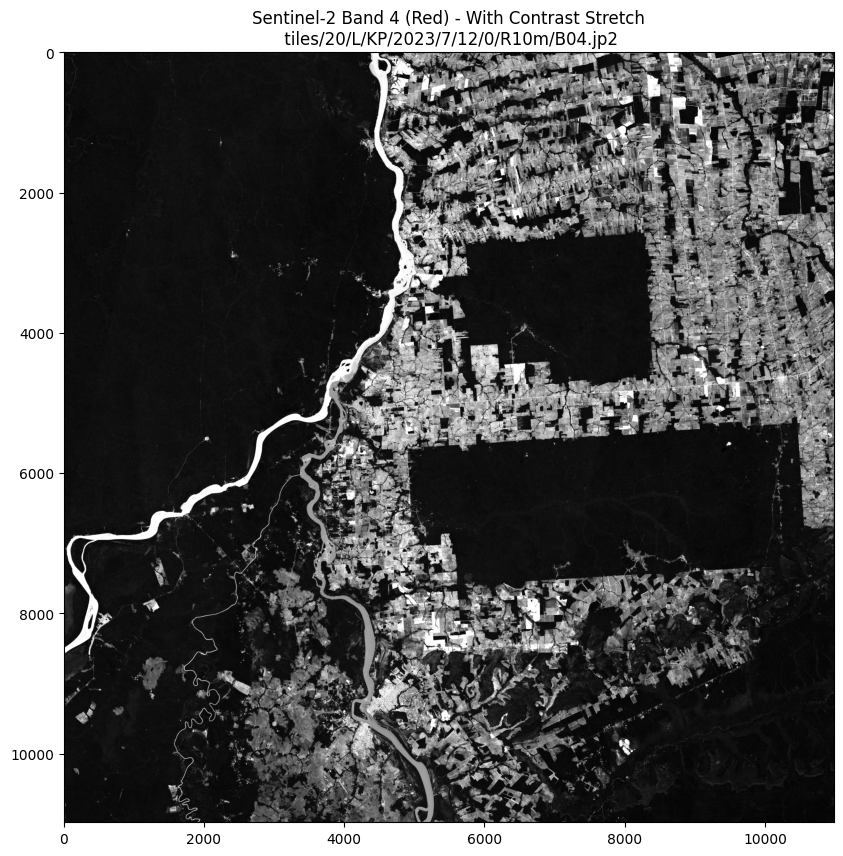

In [8]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np # We need numpy to calculate percentiles

local_filename = 'B04.jp2'

with rasterio.open(local_filename) as src:
    # 1. Read the data from the first band into a numpy array
    data = src.read(1)

    # 2. Calculate the 2nd and 98th percentile values
    # We use the data[data > 0] to ignore pure black pixels (no data) in the calculation
    p2, p98 = np.percentile(data[data > 0], (2, 98))
    
    print(f"Original min/max: {data.min()}/{data.max()}")
    print(f"Contrast stretch min/max: {p2:.0f}/{p98:.0f}")

    # --- Create the plot ---
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # 3. Display the data using our new min/max values for the color scale
    # Note: We now show the 'data' array, not the 'src' file object
    show(data, ax=ax, cmap='gray', vmin=p2, vmax=p98)

    ax.set_title(f"Sentinel-2 Band 4 (Red) - With Contrast Stretch\n {red_band_key}")
    
    plt.show()

# Download the Green and Blue Bands

In [9]:
# We start with the known valid key for the red band from Step 3
# red_band_key = 'tiles/20/L/KP/2023/7/12/0/R10m/B04.jp2'

# Create the keys for the green and blue bands by replacing the end of the string
green_band_key = red_band_key.replace('B04.jp2', 'B03.jp2')
blue_band_key = red_band_key.replace('B04.jp2', 'B02.jp2')

# Define the local filenames
green_local_filename = 'B03.jp2'
blue_local_filename = 'B02.jp2'

# --- Download the Green Band ---
print(f"Downloading Green band: {green_band_key}...")
s3.download_file(bucket_name, green_band_key, green_local_filename)
print("Green band download complete.")

# --- Download the Blue Band ---
print(f"\nDownloading Blue band: {blue_band_key}...")
s3.download_file(bucket_name, blue_band_key, blue_local_filename)
print("Blue band download complete.")

Green band download complete.

Blue band download complete.


Bands stacked successfully.
Brightness adjusted for display.


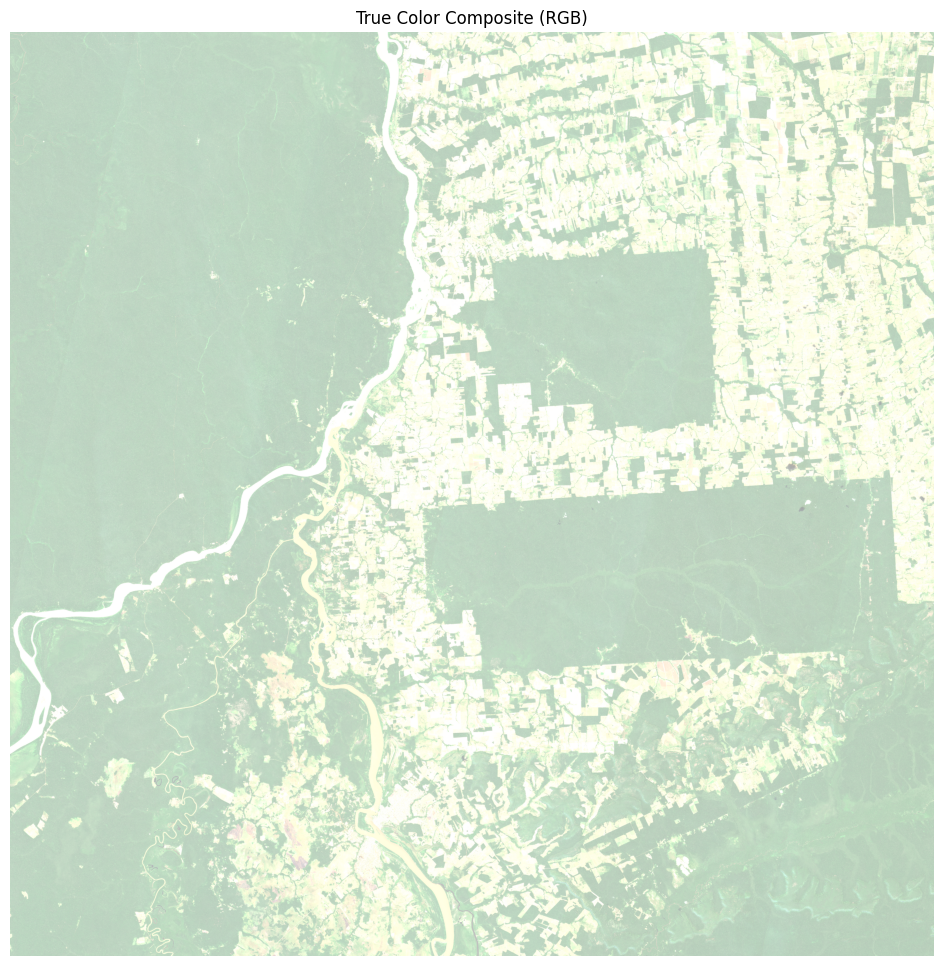

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# The local files in the correct Red, Green, Blue order
band_files = ['B04.jp2', 'B03.jp2', 'B02.jp2']

# --- 1. Open and stack the bands ---
# We open each file and read the data into a list
# This creates a 3D numpy array (height, width, bands)
with rasterio.open(band_files[0]) as r, \
     rasterio.open(band_files[1]) as g, \
     rasterio.open(band_files[2]) as b:
    rgb = np.dstack((r.read(1), g.read(1), b.read(1)))

print("Bands stacked successfully.")

# --- 2. Adjust the brightness for visualization ---
# As before, the raw data is dark. We'll apply a simple "gain"
# to make the image brighter. You can experiment with this value.
gain = 2.5

# We divide by a reasonable max value (e.g., 4000) to scale the data,
# apply our gain, and then clip the values to the displayable range [0, 1].
rgb_display = np.clip(rgb / 4000.0 * gain, 0, 1)

print("Brightness adjusted for display.")

# --- 3. Plot the final color image ---
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(rgb_display)

# Clean up the plot
ax.set_title("True Color Composite (RGB)")
ax.axis('off') # Hide the coordinate axes

plt.show()

Geolocalize the image

In [11]:
import rasterio
import pyproj

# Use one of the band files we already have
filename = 'B04.jp2'

with rasterio.open(filename) as src:
    # Get the Coordinate Reference System (CRS) from the file
    crs = src.crs
    
    # Get the coordinates of the four corners of the image
    # bounds contains (left, bottom, right, top)
    bounds = src.bounds

    # The transformer to convert from the image's CRS to WGS84 (Lat/Lon)
    transformer = pyproj.Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

    # Get the coordinates of the center of the image
    center_x = (bounds.left + bounds.right) / 2
    center_y = (bounds.top + bounds.bottom) / 2

    # Transform the center coordinate to Lat/Lon
    center_lon, center_lat = transformer.transform(center_x, center_y)

    print(f"The image is in the CRS: {crs}")
    print(f"The center of your image is at:")
    print(f"  Latitude: {center_lat:.4f}")
    print(f"  Longitude: {center_lon:.4f}\n")

    # Create a link to view this location on Google Maps
    Maps_link = f"https://www.google.com/maps/search/?api=1&query={center_lat},{center_lon}"
    print(f"View this location on Google Maps:\n{Maps_link}")

The image is in the CRS: EPSG:32720
The center of your image is at:
  Latitude: -10.4396
  Longitude: -65.2391

View this location on Google Maps:
https://www.google.com/maps/search/?api=1&query=-10.439554127437717,-65.2391271668558


# RAG

In [14]:
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# --- 1. LOAD ---

# The path to the directory containing your PDF files
doc_directory = '../docs/'

# List to hold all the loaded documents from the PDFs
all_docs = []

print(f"Loading documents from: {doc_directory}")

# Loop through all files in the directory
for filename in os.listdir(doc_directory):
    if filename.endswith('.pdf'):
        # Create the full file path
        file_path = os.path.join(doc_directory, filename)
        
        # Load the PDF
        loader = PyPDFLoader(file_path)
        documents = loader.load()
        
        # Add the loaded documents to our list
        all_docs.extend(documents)
        print(f" - Loaded {filename}")

print(f"\nTotal documents loaded: {len(all_docs)}")

# --- 2. CHUNK ---

# Now, we split the loaded documents into smaller chunks
# chunk_size is the max number of characters in a chunk
# chunk_overlap keeps some text between chunks for better context
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2048, 
    chunk_overlap=200
)

# The 'split_documents' method does the work
chunks = text_splitter.split_documents(all_docs)

print(f"Total documents chunked into: {len(chunks)} smaller pieces.")
print("\n--- Example Chunk ---")
# Print out the first chunk to see what it looks like
print(chunks[0].page_content)
print("---------------------")
print(f"Metadata: {chunks[0].metadata}")

Loading documents from: ../docs/


 - Loaded UrbanArchaeologyintheLowerAmazonFieldworkUncoveringLargePre-ColonialVillagesinSantarmCityBrazil-2-3.pdf
 - Loaded deSouza_et_al_2018.pdf
 - Loaded s41586-022-04780-4.pdf

Total documents loaded: 30
Total documents chunked into: 73 smaller pieces.

--- Example Chunk ---
See discussions, stats, and author profiles for this publication at: https://www.researchgate.net/publication/389355386
Urban Archaeology in the Lower Amazon: Fieldwork Uncovering Large Pre-
Colonial Villages in Santarém City, Brazil
Article  in   Journal of Field Archaeology · February 2025
DOI: 10.1080/00934690.2025.2466877
CITATIONS
0
READS
229
1 author:
Denise Maria Cavalcante Gomes
Federal University of Rio de Janeiro
44 PUBLICATIONS   362 CITATIONS   
SEE PROFILE
All content following this page was uploaded by Denise Maria Cavalcante Gomes on 26 February 2025.
The user has requested enhancement of the downloaded file.
---------------------
Metadata: {'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationda

In [16]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

# Load environment variables from the .env file in your project root
load_dotenv()

# This check will now work because load_dotenv() has populated the environment
if "OPENAI_API_KEY" not in os.environ:
    print("OpenAI API key not found. Make sure it's in your .env file.")
else:
    print("Found OpenAI API Key from .env file. Proceeding...")

    # Define the path for the persistent vector store
    local_path = "faiss_index"
    
    # Initialize the OpenAI embeddings model
    embeddings = OpenAIEmbeddings()

    # Check if the vector store already exists on disk
    if os.path.exists(local_path):
        # If it exists, load it from disk
        print(f"Loading existing vector store from: {local_path}")
        vectorstore = FAISS.load_local(
            local_path, 
            embeddings, 
            allow_dangerous_deserialization=True # Required for loading
        )
        print("Vector store loaded successfully.")
    else:
        # If it does not exist, create it and save it to disk
        print("No local vector store found.")
        print("Creating new vector store from documents... (This might take a moment)")
        
        # This is the original creation step
        vectorstore = FAISS.from_documents(chunks, embeddings)
        print("Vector store created successfully.")
        
        # Save the newly created vector store to disk for future sessions
        print(f"Saving new vector store to: {local_path}")
        vectorstore.save_local(local_path)
        print("Save complete.")

    print(f"\nThe vector store is ready and contains {vectorstore.index.ntotal} vectors.")

Found OpenAI API Key from .env file. Proceeding...
No local vector store found.
Creating new vector store from documents... (This might take a moment)


Vector store created successfully.
Saving new vector store to: faiss_index
Save complete.

The vector store is ready and contains 73 vectors.


In [17]:
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.prompts import ChatPromptTemplate

# 1. Initialize the Language Model
llm = ChatOpenAI(model="gpt-4o")

# 2. Create an improved prompt template with a specific persona
prompt = ChatPromptTemplate.from_template("""You are an expert archaeological remote sensing analyst. Your task is to synthesize information from the provided academic context to guide a search for new, undiscovered sites in the Amazon.

Based only on the context below, answer the user's question.

<context>
{context}
</context>

Question: {input}
""")

# 3. Create the document chain
document_chain = create_stuff_documents_chain(llm, prompt)

# 4. Create the retriever from your vector store
retriever = vectorstore.as_retriever()

# 5. Tie it all together into the final retrieval chain
retrieval_chain = create_retrieval_chain(retriever, document_chain)

print("RAG chain with analyst persona created successfully. Ready for a detailed query.")

RAG chain with analyst persona created successfully. Ready for a detailed query.


In [18]:
# This is our detailed, structured question.
# We are asking the AI to act on the information and format the output.
question = """
Based on the provided texts, identify 3-5 promising geographical regions for discovering new archaeological sites.

For each proposed region, please provide the following in a structured format:
1.  **Region Name:** A descriptive name for the area (e.g., Upper Xingu River Basin, Interfluve between the Purus and Madeira rivers).
2.  **Geographical Clues:** Summarize the environmental characteristics described in the papers that make this region promising (e.g., proximity to specific types of rivers, soil types like Terra Preta, elevation like bluffs or plateaus).
3.  **Expected Site Types:** List the kinds of undiscovered sites the papers suggest might be found here (e.g., mound villages, ring ditches, geoglyphs, causeways).
4.  **Supporting Rationale:** Briefly explain your reasoning, referencing patterns or statements from the provided context.
"""

print("Invoking RAG chain with detailed question... (This may take a moment)")
response = retrieval_chain.invoke({"input": question})

# Print the final answer from the LLM
print("\n--- Generated Hypotheses ---")
print(response["answer"])

Invoking RAG chain with detailed question... (This may take a moment)

--- Generated Hypotheses ---
1. **Region Name:** Upper Tapajós Basin (UTB)
   - **Geographical Clues:** The region features relatively flat landscapes with gentle hills, elevations between 100–300 m, and is located between the Juruena and Aripuanã rivers. Areas of residual plateaus and small plateaus overlooking rivers and streams are common.
   - **Expected Site Types:** Ditched enclosures, circular mounded villages, compounds with multiple enclosures, and sites with Amazonian Dark Earth (ADE) and ceramics.
   - **Supporting Rationale:** The Upper Tapajós Basin has recently been surveyed, discovering 81 new Pre-Columbian sites, filling a gap in Amazonian archaeology. The presence of ADE and ceramics suggests long-term human occupation, indicating the area is promising for future discoveries of similar sites.

2. **Region Name:** Upper Xingu
   - **Geographical Clues:** Known for having a high diversity of language 